![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Agents Lab Notebook v1.0.0
This notebook contains steps and code to demonstrate the use of agents
configured in Agent Lab in watsonx.ai. It introduces Python API commands
for authentication using API key and invoking a LangGraph agent with a watsonx chat model.

**Note:** Notebook code generated using Agent Lab will execute successfully.
If code is modified or reordered, there is no guarantee it will successfully execute.
For details, see: <a href="/docs/content/wsj/analyze-data/fm-prompt-save.html?context=wx" target="_blank">Saving your work in Agent Lab as a notebook.</a>

Some familiarity with Python is helpful. This notebook uses Python 3.11.

## Notebook goals
The learning goals of this notebook are:

* Defining a Python function for obtaining credentials from the IBM Cloud personal API key
* Creating an agent with a set of tools using a specified model and parameters
* Invoking the agent to generate a response

# Setup

In [1]:
!pip install langchain langgraph
!pip install ibm-watsonx-ai
!pip install langchain-ibm
!pip install requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 522.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 638.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 5.4 MB/s eta 0:00:00
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.14.3-py3-none-any.whl size=77

In [3]:
from langchain_ibm import ChatWatsonx
from ibm_watsonx_ai import APIClient
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from ibm_watsonx_ai.foundation_models.utils import Tool, Toolkit
import json
import requests

## watsonx API connection
This cell defines the credentials required to work with watsonx API for Foundation
Model inferencing.

**Action:** Provide the IBM Cloud personal API key. For details, see
<a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank">documentation</a>.


In [4]:
import os
import getpass

def get_credentials():
    return {
        "url": "https://us-south.ml.cloud.ibm.com",
        "apikey": getpass.getpass("Please enter your API key (hit enter): ")
    }

def get_bearer_token():
    url = "https://iam.cloud.ibm.com/identity/token"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = f"grant_type=urn:ibm:params:oauth:grant-type:apikey&apikey={credentials['apikey']}"
    response = requests.post(url, headers=headers, data=data)
    return response.json().get("access_token")

credentials = get_credentials()


Please enter your API key (hit enter): ··········


# Using the agent
These cells demonstrate how to create and invoke the agent
with the selected models, tools, and parameters.

## Defining the model id
We need to specify model id that will be used for inferencing:

In [5]:
model_id = "ibm/granite-3-3-8b-instruct"

## Defining the model parameters
We need to provide a set of model parameters that will influence the
result:

In [7]:
parameters = {
    "frequency_penalty": 0,
    "max_tokens": 2000,
    "presence_penalty": 0,
    "temperature": 0,
    "top_p": 1
}

## Defining the project id or space id
The API requires project id or space id that provides the context for the call. We will obtain
the id from the project or space in which this notebook runs:

In [8]:
project_id = "79d31299-e8bd-4df8-ae19-d0672eb66c13"

## Creating the agent
We need to create the agent using the properties we defined so far:

In [9]:
client = APIClient(credentials=credentials, project_id=project_id)

def create_chat_model():
    chat_model = ChatWatsonx(
        model_id=model_id,
        url=credentials["url"],
        project_id=project_id,
        params=parameters,
        watsonx_client=client,
    )
    return chat_model

In [10]:
from ibm_watsonx_ai.deployments import RuntimeContext

context = RuntimeContext(api_client=client)

In [11]:
vector_index_id = "03f74ef4-32e5-4366-9d67-d01e2129b9fb"

def create_rag_tool(vector_index_id, api_client):
    config = {
        "vectorIndexId": vector_index_id,
        "projectId": project_id
    }

    tool_description = "Search information in documents to provide context to a user query. Useful when asked to ground the answer in specific knowledge about Diabetes."

    return create_utility_agent_tool("RAGQuery", config, api_client, tool_description=tool_description)


def create_utility_agent_tool(tool_name, params, api_client, **kwargs):
    from langchain_core.tools import StructuredTool
    utility_agent_tool = Toolkit(api_client=api_client).get_tool(tool_name)

    tool_description = utility_agent_tool.get("description")

    if kwargs.get("tool_description"):
        tool_description = kwargs["tool_description"]
    elif utility_agent_tool.get("agent_description"):
        tool_description = utility_agent_tool.get("agent_description")

    tool_schema = utility_agent_tool.get("input_schema") or {
        "type": "object",
        "additionalProperties": False,
        "$schema": "http://json-schema.org/draft-07/schema#",
        "properties": {
            "input": {
                "description": "input for the tool",
                "type": "string"
            }
        }
    }

    def run_tool(**tool_input):
        query = tool_input
        if utility_agent_tool.get("input_schema") is None:
            query = tool_input.get("input")

        results = utility_agent_tool.run(input=query, config=params)
        return results.get("output")

    return StructuredTool(
        name=tool_name,
        description=tool_description,
        func=run_tool,
        args_schema=tool_schema
    )

In [12]:
def create_tools(context):
    tools = []
    tools.append(create_rag_tool(vector_index_id, client))

    tools.append(create_utility_agent_tool("GoogleSearch", None, client))
    tools.append(create_utility_agent_tool("DuckDuckGo", {}, client))
    tools.append(create_utility_agent_tool("Wikipedia", {"maxResults": 5}, client))
    tools.append(create_utility_agent_tool("WebCrawler", {}, client))

    return tools

In [13]:
def create_agent(context):
    chat_model = create_chat_model()
    tools = create_tools(context)

    memory = MemorySaver()
    instructions = """# Notes
- When a tool is required to answer the user's query, respond only with <|tool_call|> followed by a JSON list of tools used.
- If a tool does not exist in the provided list of tools, notify the user that you do not have the ability to fulfill the request.
You are MediQuery, an AI-powered health assistant. Use verified medical PDFs (WHO and government sources) as your primary knowledge base, and retrieve additional information from trusted sites in real time when needed. Provide clear, multilingual, educational health guidance on symptoms, possible conditions, treatments, and prevention. Do not give diagnoses or prescriptions."""

    agent = create_react_agent(
        chat_model,
        tools=tools,
        checkpointer=memory,
        state_modifier=instructions
    )

    return agent

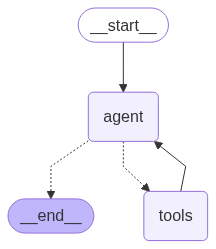

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

Image(
    create_agent(context).get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API,
    )
)

## Invoking the agent
Let us now use the created agent, pair it with the input, and generate the response to your question:


In [15]:
agent = create_agent(context)

def convert_messages(messages):
    return [
        HumanMessage(content=msg["content"]) if msg["role"] == "user"
        else AIMessage(content=msg["content"])
        for msg in messages
    ]

question = input("Question: ")

messages = [{"role": "user", "content": question}]

response = agent.invoke(
    {"messages": convert_messages(messages)},
    {"configurable": {"thread_id": "42"}}
)

print("Agent:", response["messages"][-1].content)

Question: how can i treat the symptoms of common cold
Agent: To treat the symptoms of a common cold, you can follow these general recommendations:

1. **Stay Hydrated**: Drink plenty of fluids to prevent dehydration. Water, clear broth, and herbal teas are good choices. Avoid alcohol and caffeine, as they can dehydrate you.

2. **Rest**: Your body needs rest to fight off the virus. Make sure to get plenty of sleep.

3. **Over-the-counter Medications**: Use over-the-counter (OTC) cold remedies to relieve symptoms. Decongestants can help with a stuffy nose, while pain relievers like acetaminophen or ibuprofen can reduce fever and ease aches.

4. **Saline Nasal Sprays**: These can help relieve a stuffy nose.

5. **Humidify the Air**: Use a humidifier to add moisture to the air, which can help soothe a sore throat and nasal passages.

6. **Gargle with Salt Water**: Gargling with warm salt water can help relieve a sore throat.

7. **Eat Healthy**: Consume nutritious foods to boost your immu